In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb


In [2]:
# Load and aggregate transactions to daily sales (USD)
trans = pd.read_csv('Dataset/transactions.csv')
trans_each_inID = trans.groupby([
    'Invoice ID','Customer ID','Date','Store ID','Employee ID','Currency','Transaction Type'
]).agg({'Product ID': list, 'Line Total': 'sum'}).reset_index()

trans_each_inID['Date'] = pd.to_datetime(trans_each_inID['Date'])

# Currency normalization
exchange_rates = pd.DataFrame({
    'Currency': ['USD','CNY','GBP','EUR'],
    'to_USD':  [1.00, 0.14, 1.33, 1.16]
})
trans_each_inID = trans_each_inID.merge(exchange_rates, on='Currency', how='left')
trans_each_inID['to_USD'] = trans_each_inID['to_USD'].fillna(1.0)
trans_each_inID['Line Total'] = trans_each_inID['Line Total'] * trans_each_inID['to_USD']

# Daily sales
daily_sales = (
    trans_each_inID.groupby(trans_each_inID['Date'].dt.date)['Line Total']
    .sum()
    .rename('daily_total_usd')
    .reset_index()
)
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])

daily_sales.head()


,Date,daily_total_usd
0,2023-01-01,759856.5580
1,2023-01-02,177565.8705
2,2023-01-03,158566.6598
3,2023-01-04,164006.1005
4,2023-01-05,157792.9851


In [3]:
# Feature engineering similar to LightGBM adjustments
# Sort
daily_sales = daily_sales.sort_values('Date').reset_index(drop=True)

# Calendar basics
daily_sales['year'] = daily_sales['Date'].dt.year
daily_sales['month'] = daily_sales['Date'].dt.month
daily_sales['day'] = daily_sales['Date'].dt.day
daily_sales['day_of_week'] = daily_sales['Date'].dt.dayofweek
daily_sales['day_of_year'] = daily_sales['Date'].dt.dayofyear
daily_sales['week_of_year'] = daily_sales['Date'].dt.isocalendar().week
daily_sales['quarter'] = daily_sales['Date'].dt.quarter

# Weekend and holiday
daily_sales['is_weekend'] = (daily_sales['day_of_week'] >= 5).astype(int)
holiday_md = {(1,1),(2,14),(4,30),(5,1),(9,2),(12,24),(12,25),(12,31)}
daily_sales['is_holiday'] = daily_sales['Date'].apply(lambda d: int((d.month, d.day) in holiday_md))

# Lags: keep lag_7; add lag_28 for long horizon; keep 1,14,30 for context
for lag in [1, 7, 14, 28, 30]:
    daily_sales[f'lag_{lag}'] = daily_sales['daily_total_usd'].shift(lag)

# Use only past information (shift by 1) to avoid leakage
_prev = daily_sales['daily_total_usd'].shift(1)

# Rolling means: keep only 30 (using past only)
daily_sales['rolling_mean_30'] = _prev.rolling(window=30, min_periods=1).mean()

# Rolling std for short/long variability (using past only)
for w in [7, 30]:
    daily_sales[f'rolling_std_{w}'] = _prev.rolling(window=w, min_periods=2).std(ddof=0)

# EMA: keep ema_7 for trend (using past only)
daily_sales['ema_7'] = _prev.ewm(span=7, adjust=False).mean()

# Trend: keep only diff_1 (drop diff_7)
daily_sales['diff_1'] = daily_sales['daily_total_usd'].diff(1)

# Cyclical encodings
daily_sales['month_sin'] = np.sin(2 * np.pi * daily_sales['month'] / 12)
daily_sales['month_cos'] = np.cos(2 * np.pi * daily_sales['month'] / 12)
daily_sales['day_of_week_sin'] = np.sin(2 * np.pi * daily_sales['day_of_week'] / 7)
daily_sales['day_of_week_cos'] = np.cos(2 * np.pi * daily_sales['day_of_week'] / 7)
daily_sales['day_of_year_sin'] = np.sin(2 * np.pi * daily_sales['day_of_year'] / 365)
daily_sales['day_of_year_cos'] = np.cos(2 * np.pi * daily_sales['day_of_year'] / 365)

print(f"Tổng số features: {len(daily_sales.columns)}")
print(f"Shape: {daily_sales.shape}")
daily_sales.head()


Tổng số features: 27
Shape: (808, 27)


,Date,daily_total_usd,year,month,day,day_of_week,day_of_year,week_of_year,quarter,is_weekend,...,rolling_std_7,rolling_std_30,ema_7,diff_1,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos
0,2023-01-01,759856.5580,2023,1,1,6,1,52,1,1,...,NaN,NaN,NaN,NaN,0.5,0.866025,-0.781831,0.623490,0.017213,0.999852
1,2023-01-02,177565.8705,2023,1,2,0,2,1,1,0,...,NaN,NaN,759856.558000,-582290.6875,0.5,0.866025,0.000000,1.000000,0.034422,0.999407
2,2023-01-03,158566.6598,2023,1,3,1,3,1,1,0,...,291145.343750,291145.343750,614283.886125,-18999.2107,0.5,0.866025,0.781831,0.623490,0.051620,0.998667
3,2023-01-04,164006.1005,2023,1,4,2,4,1,1,0,...,279080.425770,279080.425770,500354.579544,5439.4407,0.5,0.866025,0.974928,-0.222521,0.068802,0.997630
4,2023-01-05,157792.9851,2023,1,5,3,5,1,1,0,...,256931.919365,256931.919365,416267.459783,-6213.1154,0.5,0.866025,0.433884,-0.900969,0.085965,0.996298


In [4]:
# Prepare modeling data (drop initial NaNs from lags)
df_model = daily_sales.dropna().copy()
feature_cols = [c for c in df_model.columns if c not in ['Date','daily_total_usd']]
X = df_model[feature_cols]
y = df_model['daily_total_usd']

print(f"Features: {len(feature_cols)} | Samples: {len(df_model)}")



Features: 25 | Samples: 778


In [5]:
# 70/20/10 time-ordered split
n = len(df_model)
train_end = int(n * 0.7)
val_end = int(n * 0.9)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val,   y_val   = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test,  y_test  = X.iloc[val_end:], y.iloc[val_end:]

print(f"Train: {len(X_train)} ({df_model.iloc[0]['Date'].date()} → {df_model.iloc[train_end-1]['Date'].date()})")
print(f"Val  : {len(X_val)} ({df_model.iloc[train_end]['Date'].date()} → {df_model.iloc[val_end-1]['Date'].date()})")
print(f"Test : {len(X_test)} ({df_model.iloc[val_end]['Date'].date()} → {df_model.iloc[-1]['Date'].date()})")



Train: 544 (2023-01-31 → 2024-07-27)
Val  : 156 (2024-07-28 → 2024-12-30)
Test : 78 (2024-12-31 → 2025-03-18)


In [6]:
# Train XGBoost with validation early stopping
model = xgb.XGBRegressor(
    n_estimators=2500,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.6,
    colsample_bytree=0.6,
    min_child_weight=30,
    gamma=5.0,
    reg_alpha=5.0,
    reg_lambda=20.0,
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist',
    eval_metric='rmse'
)

print("Training XGBoost...")
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)
print("Done.")


Training XGBoost...
[0]	validation_0-rmse:204463.39736	validation_1-rmse:347074.75972
[100]	validation_0-rmse:142794.22914	validation_1-rmse:273941.53716
[200]	validation_0-rmse:114989.59350	validation_1-rmse:235324.29886
[300]	validation_0-rmse:99864.76953	validation_1-rmse:211696.61705
[400]	validation_0-rmse:91067.92819	validation_1-rmse:196119.17586
[500]	validation_0-rmse:84899.13304	validation_1-rmse:184927.20749
[600]	validation_0-rmse:80214.13269	validation_1-rmse:175822.05380
[700]	validation_0-rmse:76103.72914	validation_1-rmse:168169.05354
[800]	validation_0-rmse:72794.86647	validation_1-rmse:161843.08956
[900]	validation_0-rmse:69968.09628	validation_1-rmse:156953.94975
[1000]	validation_0-rmse:67328.00374	validation_1-rmse:152155.48313
[1100]	validation_0-rmse:65064.01675	validation_1-rmse:147931.29152
[1200]	validation_0-rmse:62939.56571	validation_1-rmse:144228.62736
[1300]	validation_0-rmse:61113.73972	validation_1-rmse:140847.43966
[1400]	validation_0-rmse:59473.19725	

XGBoost Results
Train: MAE=18,557.18, RMSE=46,651.69, R2=0.9484
Val  : MAE=63,967.74, RMSE=117,202.86, R2=0.8543
Test : MAE=23,535.62, RMSE=37,240.26, R2=0.9415, MAPE=9.44%


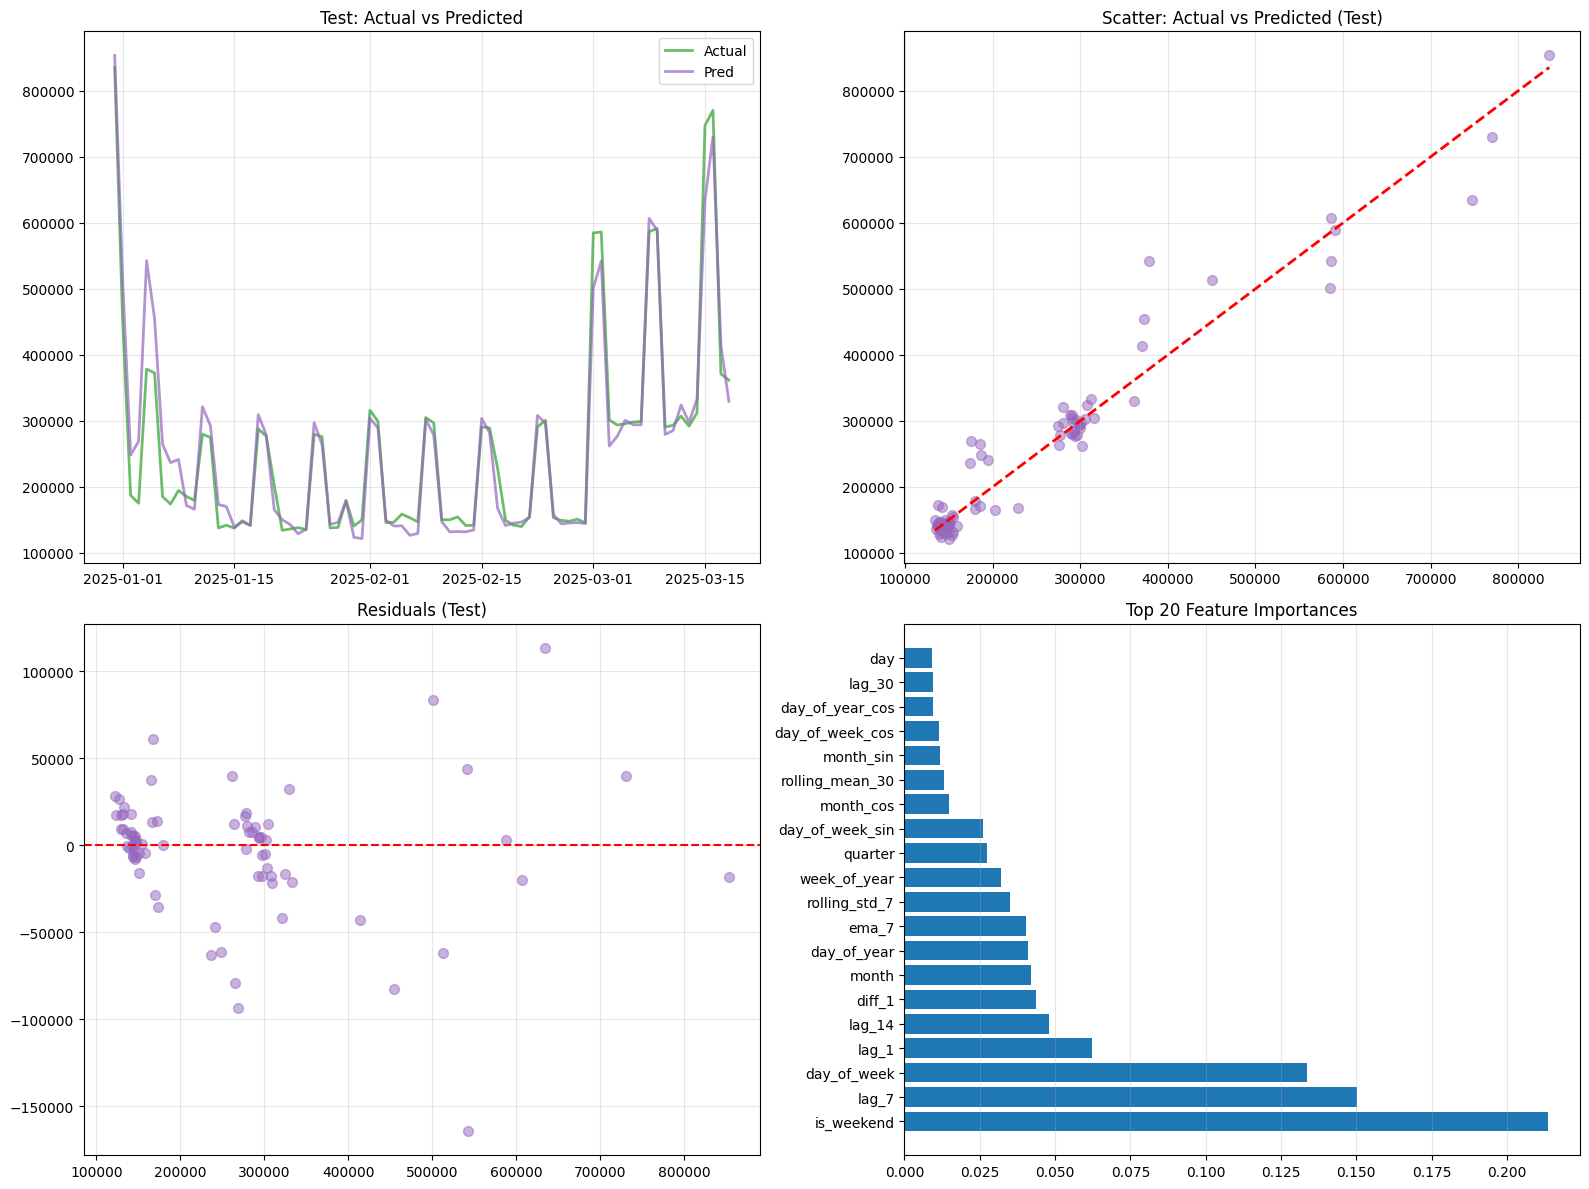

In [7]:
# Evaluate and visualize
best_ntree = getattr(model, 'best_iteration', None)

if best_ntree is not None:
    y_train_pred = model.predict(X_train, iteration_range=(0, best_ntree + 1))
    y_val_pred   = model.predict(X_val,   iteration_range=(0, best_ntree + 1))
    y_test_pred  = model.predict(X_test,  iteration_range=(0, best_ntree + 1))
else:
    y_train_pred = model.predict(X_train)
    y_val_pred   = model.predict(X_val)
    y_test_pred  = model.predict(X_test)

# Metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

mape_test = (np.mean(np.abs(y_test - y_test_pred) / np.maximum(np.abs(y_test), 1e-8)) * 100)

print("="*60)
print("XGBoost Results")
print("="*60)
print(f"Train: MAE={train_mae:,.2f}, RMSE={train_rmse:,.2f}, R2={train_r2:.4f}")
print(f"Val  : MAE={val_mae:,.2f}, RMSE={val_rmse:,.2f}, R2={val_r2:.4f}")
print(f"Test : MAE={test_mae:,.2f}, RMSE={test_rmse:,.2f}, R2={test_r2:.4f}, MAPE={mape_test:.2f}%")

# Plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1) Time series test actual vs predicted
axes[0, 0].plot(df_model.iloc[val_end:]['Date'], y_test.values, label='Actual', linewidth=2, alpha=0.7, color='tab:green')
axes[0, 0].plot(df_model.iloc[val_end:]['Date'], y_test_pred, label='Pred', linewidth=2, alpha=0.7, color='tab:purple')
axes[0, 0].set_title('Test: Actual vs Predicted')
axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)

# 2) Scatter
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.5, s=50, color='tab:purple')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_title('Scatter: Actual vs Predicted (Test)')
axes[0, 1].grid(True, alpha=0.3)

# 3) Residuals
residuals = y_test - y_test_pred
axes[1, 0].scatter(y_test_pred, residuals, alpha=0.5, s=50, color='tab:purple')
axes[1, 0].axhline(0, color='r', linestyle='--')
axes[1, 0].set_title('Residuals (Test)')
axes[1, 0].grid(True, alpha=0.3)

# 4) Feature importance (gain)
fi = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(20)
axes[1, 1].barh(range(len(fi)), fi['importance'])
axes[1, 1].set_yticks(range(len(fi)))
axes[1, 1].set_yticklabels(fi['feature'])
axes[1, 1].set_title('Top 20 Feature Importances')
axes[1, 1].grid(True, axis='x', alpha=0.3)

plt.tight_layout(); plt.show()


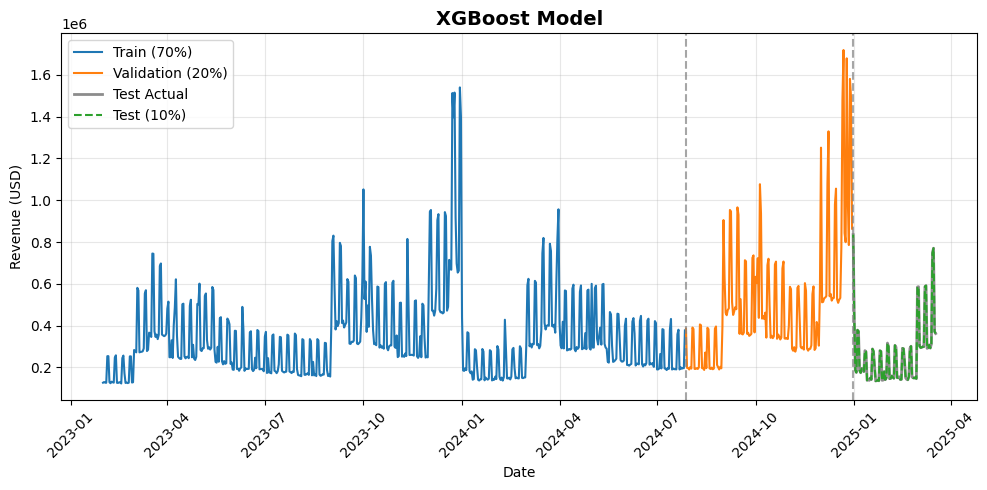

In [9]:
# Segment plot: Train / Validation / Test
plt.figure(figsize=(10, 5))
plt.plot(df_model['Date'].iloc[:train_end], df_model['daily_total_usd'].iloc[:train_end], label='Train (70%)', color='tab:blue')
plt.plot(df_model['Date'].iloc[train_end:val_end], df_model['daily_total_usd'].iloc[train_end:val_end], label='Validation (20%)', color='tab:orange')
plt.plot(
    df_model['Date'].iloc[val_end:],
    y_test.values,          # dữ liệu thực tế Test
    label='Test Actual',
    color='gray', linewidth=2, alpha=0.9
)
plt.plot(df_model['Date'].iloc[val_end:], df_model['daily_total_usd'].iloc[val_end:], label='Test (10%)', color='tab:green',linestyle='--')
plt.axvline(df_model['Date'].iloc[train_end], color='gray', linestyle='--', alpha=0.7)
plt.axvline(df_model['Date'].iloc[val_end], color='gray', linestyle='--', alpha=0.7)
plt.title('XGBoost Model',fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Revenue (USD)')
plt.legend(); plt.grid(True, alpha=0.3); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()
